# Graph Building Notebook

Author: Christian Spiteri Gauci

## Method

* Graph data as an output from the post_feature_engineering is loaded
* Nodes - Every subreddit and every word2 - word2 being noun/pronoun, subreddit being the mental health diseases
* Going through every entry, if node already exist - use it, if not create a new one
* comparing word2 (noun) with subreddit entries - if the same, the subreddit node is to be used and points to itself, or to another subreddit node
* Word 1 (the verb) is the relationship between the nodes (subreddit and word2)
* The direction of the relationship is determined by the semantics of the sentence - dobj or nsubj





In [26]:
import pandas as pd
import numpy as np
from py2neo import Graph, Node, Relationship
import ast
import os
from dotenv import load_dotenv
from os import getenv
from concurrent.futures import ThreadPoolExecutor
import gc
import concurrent.futures
from tqdm import tqdm
import threading
import networkx as nx
import matplotlib.pyplot as plt

In [15]:
df = pd.read_csv("./data/GraphData.csv")

In [16]:
# sample_percentage = 0.1
num_rows = 1000

# sampled_df = df.sample(frac=sample_percentage, random_state=42) 
sampled_df = df.sample(n=num_rows, random_state=42)

sampled_df.to_csv("./data/GraphData_sampled.csv", index=False)

From Spacy: https://github.com/clir/clearnlp-guidelines/blob/master/md/specifications/dependency_labels.md

nsubj - nominal subject (verb (action) performed by the NS)
dobj - direct object  (verb (action) performed on the DO)

This is used to determine the direction of the relationship.

In [17]:
load_dotenv()
client_id = os.getenv('N4J_USER')
client_secret = os.getenv('N4J_PW')
# assert client_id is not None and client_secret is not None

graph = Graph(uri="bolt://localhost:7687", auth=("neo4j", "letmein1234"))
# graph = Graph(uri="bolt://localhost:7687", auth=(client_id, client_secret))

graph.delete_all()
existing_nodes = {}
tx = graph.begin()

for row in tqdm(sampled_df.itertuples(), total=len(sampled_df), desc="Processing Rows", position=0):
    # Check if the Subreddit node already exists
    existing_subreddit = existing_nodes.get(row.Subreddit.lower())

    if existing_subreddit:
        subreddit_node = existing_subreddit
    else:
        subreddit_node = Node("Mental_Health_Disorder", name=row.Subreddit.lower()) 
        tx.create(subreddit_node)
        existing_nodes[row.Subreddit.lower()] = subreddit_node

    
    # Check if the Word node already exists
    word2_lowercase = row.Word2.lower()
    existing_word = existing_nodes.get(word2_lowercase)   

    if word2_lowercase == row.Subreddit.lower():
        word2_node = subreddit_node  # Use the Subreddit node for Word2
    elif existing_word:
        word2_node = existing_word
    else:
        word2_node = Node("Word", name=word2_lowercase)
        tx.create(word2_node)
        existing_nodes[word2_lowercase] = word2_node


    mh_labels_dict = ast.literal_eval(row.MHlabels)

    # Determine the relationship direction based on 'Dependency'
    if row.Dependency == 'dobj':
        # If 'Dependency' is 'dobj', create relationship from 'Subreddit' to 'Word2'
        relationship = Relationship(subreddit_node, row.Word1, word2_node, **mh_labels_dict)
    elif row.Dependency == 'nsubj':
        # If 'Dependency' is 'nsubj', create relationship from 'Word2' to 'Subreddit'
        relationship = Relationship(word2_node, row.Word1, subreddit_node, **mh_labels_dict)
    else:
        continue

    tx.create(relationship)

print()
graph.commit(tx)


Processing Rows:   0%|          | 0/1000 [00:00<?, ?it/s]

Processing Rows: 100%|██████████| 1000/1000 [00:02<00:00, 421.75it/s]

In the code above, we have Word2 (pronoun) connected directly to Subreddit(Class) via Word1 (Verb).
However this means that we are losing interconnectivity infomration.

For example:
Entry 1:  Steal(Word1), nsubj, Man(Word2)
Entry 2: Steal(Word1), dobj, Purse(Word2)

From the graph above, i can never link the two lines mentioned above. since there won't be a connection.

Below the graph is fixed to have Word2 connected to Word1 via a directional edge (relationship) and then this is connected to the Class. This way the graph holds a lot more information and more meaningful analysis can be performed

In [21]:
from tqdm import tqdm
from py2neo import Node, Relationship, Graph
import ast
import os
from dotenv import load_dotenv

load_dotenv()

client_id = os.getenv('N4J_USER')
client_secret = os.getenv('N4J_PW')

graph = Graph(uri="bolt://localhost:7687", auth=("neo4j", "letmein1234"))
# graph = Graph(uri="bolt://localhost:7687", auth=(client_id, client_secret))

graph.delete_all()
existing_nodes = {}
tx = graph.begin()

for row in tqdm(sampled_df.itertuples(), total=len(sampled_df), desc="Processing Rows", position=0):
    # Check if the Subreddit node already exists
    existing_subreddit = existing_nodes.get(row.Subreddit.lower())

    if existing_subreddit:
        subreddit_node = existing_subreddit
    else:
        subreddit_node = Node("Mental_Health_Disorder", name=row.Subreddit.lower()) 
        tx.create(subreddit_node)
        existing_nodes[row.Subreddit.lower()] = subreddit_node

    # Check if the Word1 node already exists
    word1_lowercase = row.Word1.lower()
    existing_word1 = existing_nodes.get(word1_lowercase)

    if existing_word1:
        word1_node = existing_word1
    else:
        word1_node = Node("Verb", name=word1_lowercase)
        tx.create(word1_node)
        existing_nodes[word1_lowercase] = word1_node

        # Connect Word1 to the Subreddit class
        relationship_subreddit_to_word1 = Relationship(subreddit_node, "HAS_WORD", word1_node)
        tx.create(relationship_subreddit_to_word1)

    # Check if the Word2 node already exists
    word2_lowercase = row.Word2.lower()
    existing_word2 = existing_nodes.get(word2_lowercase)

    if word2_lowercase == row.Subreddit.lower():
        word2_node = subreddit_node  # Use the Subreddit node for Word2
    elif existing_word2:
        word2_node = existing_word2
    else:
        word2_node = Node("Word", name=word2_lowercase)
        tx.create(word2_node)
        existing_nodes[word2_lowercase] = word2_node

    mh_labels_dict = ast.literal_eval(row.MHlabels)

    # Determine the relationship direction based on 'Dependency'
    if row.Dependency == 'dobj':
        # If 'Dependency' is 'dobj', create relationship from Word1 to Word2
        relationship_word1_to_word2 = Relationship(word1_node, row.Dependency, word2_node, **mh_labels_dict)
        tx.create(relationship_word1_to_word2)
    elif row.Dependency == 'nsubj':
        # If 'Dependency' is 'nsubj', create relationship from Word2 to Word1
        relationship_word2_to_word1 = Relationship(word2_node, row.Dependency, word1_node, **mh_labels_dict)
        tx.create(relationship_word2_to_word1)
    else:
        continue

print()
graph.commit(tx)


Processing Rows: 100%|██████████| 1000/1000 [00:04<00:00, 228.82it/s]

In [ ]:
# Query to return all nodes in the graph
query = "MATCH (n) return n"
graph.run(query).data()

Identifying Key Nodes

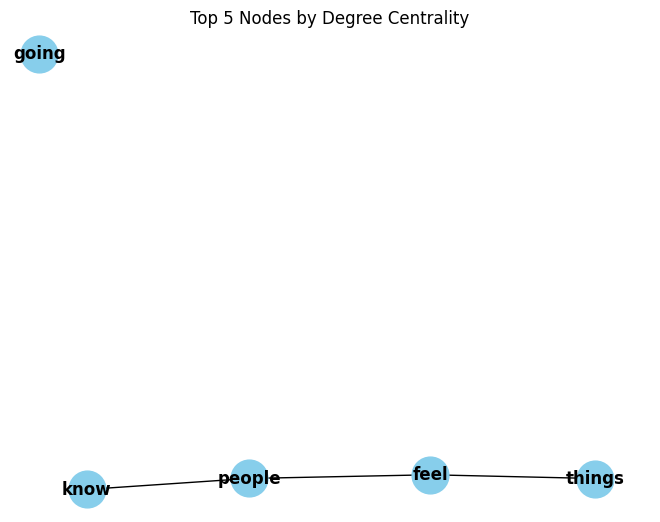

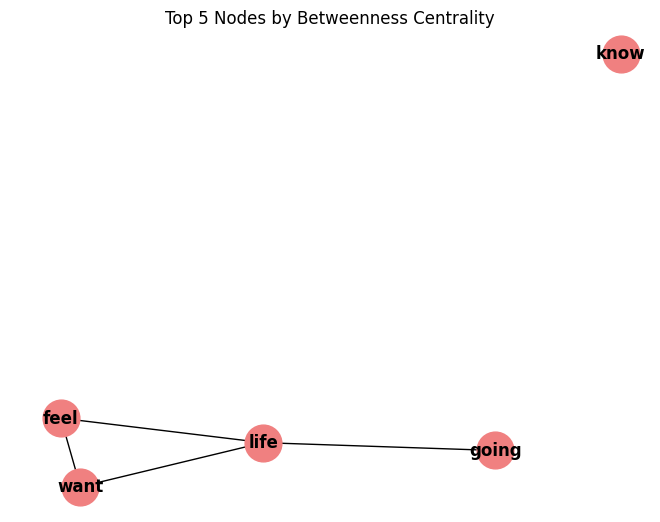

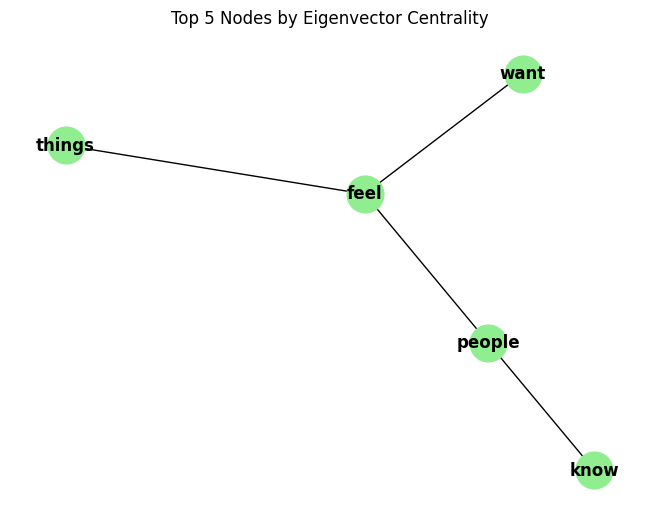

In [32]:
# Cypher query to get nodes and their labels, excluding nodes of type "Mental_Health_Disorder"
query = """
MATCH (n)
WHERE NOT n:Mental_Health_Disorder
RETURN id(n) as id, n.name as label
"""

result = graph.run(query)
node_labels = {record['id']: record['label'] for record in result}

# Cypher query to get relationships and their nodes, excluding nodes of type "Mental_Health_Disorder"
query = """
MATCH (n)-[r]->(m)
WHERE NOT n:Mental_Health_Disorder AND NOT m:Mental_Health_Disorder
RETURN id(n) as source, id(m) as target
"""

result = graph.run(query)
edges = [(record['source'], record['target']) for record in result]

G = nx.Graph(edges)

# Calculate Degree Centrality
degree_centrality = nx.degree_centrality(G)

top_degree_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:5]

subgraph_degree = G.subgraph(top_degree_nodes)
labels_degree = {node: node_labels[node] for node in subgraph_degree.nodes}
pos_degree = nx.spring_layout(subgraph_degree)
nx.draw(subgraph_degree, pos_degree, with_labels=True, labels=labels_degree, font_weight='bold', node_size=700, node_color='skyblue')
plt.title('Top 5 Nodes by Degree Centrality')
plt.show()

# Calculate Betweenness Centrality
betweenness_centrality = nx.betweenness_centrality(G)

top_betweenness_nodes = sorted(betweenness_centrality, key=betweenness_centrality.get, reverse=True)[:5]

subgraph_betweenness = G.subgraph(top_betweenness_nodes)
labels_betweenness = {node: node_labels[node] for node in subgraph_betweenness.nodes}
pos_betweenness = nx.spring_layout(subgraph_betweenness)
nx.draw(subgraph_betweenness, pos_betweenness, with_labels=True, labels=labels_betweenness, font_weight='bold', node_size=700, node_color='lightcoral')
plt.title('Top 5 Nodes by Betweenness Centrality')
plt.show()

# Calculate Eigenvector Centrality
eigenvector_centrality = nx.eigenvector_centrality(G)

top_eigenvector_nodes = sorted(eigenvector_centrality, key=eigenvector_centrality.get, reverse=True)[:5]

subgraph_eigenvector = G.subgraph(top_eigenvector_nodes)
labels_eigenvector = {node: node_labels[node] for node in subgraph_eigenvector.nodes}
pos_eigenvector = nx.spring_layout(subgraph_eigenvector)
nx.draw(subgraph_eigenvector, pos_eigenvector, with_labels=True, labels=labels_eigenvector, font_weight='bold', node_size=700, node_color='lightgreen')
plt.title('Top 5 Nodes by Eigenvector Centrality')
plt.show()

Community Detection - Using Louvain Algorithm

C:\Users\chris\AppData\Local\Temp\ipykernel_9776\2678844678.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)


KeyError: 99022

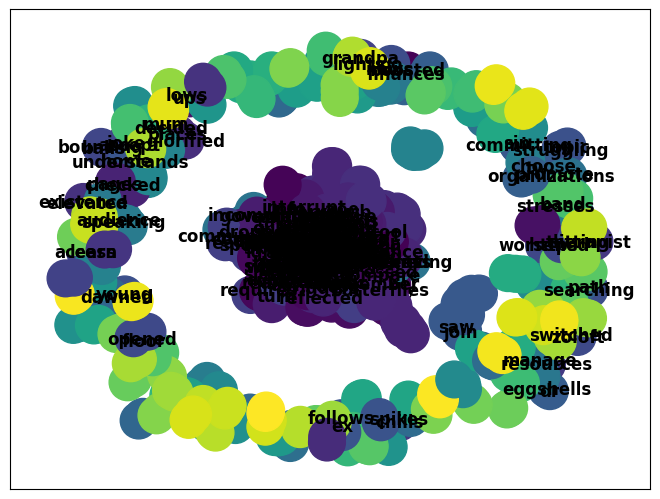

In [36]:
import community

# Cypher query to get nodes and their labels, excluding nodes of type "Mental_Health_Disorder"
query = """
MATCH (n)
WHERE NOT n:Mental_Health_Disorder
RETURN id(n) as id, n.name as label
"""

result = graph.run(query)
node_labels = {record['id']: record['label'] for record in result}

# Cypher query to get relationships and their nodes, excluding nodes of type "Mental_Health_Disorder"
query = """
MATCH (n)-[r]->(m)
WHERE NOT n:Mental_Health_Disorder AND NOT m:Mental_Health_Disorder
RETURN id(n) as source, id(m) as target
"""

result = graph.run(query)
edges = [(record['source'], record['target']) for record in result]

# Create a networkx graph from the edges
G = nx.Graph(edges)

# Perform Louvain community detection
partition = community.best_partition(G)

# Filter nodes that have positions in the layout
pos_filtered = {node_id: pos[node_id] for node_id in pos if node_id in partition}

# Draw the graph with communities color-coded
cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw(G, pos=pos_filtered, node_color=list(partition.values()), cmap=cmap, with_labels=True, labels=node_labels, font_weight='bold', node_size=700)
plt.title('Community Detection (Excluding Mental_Health_Disorder)')
plt.show()